# Advanced Lane Finding Project

In [1]:
import os
import glob
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### 1. Camera  Calibration
Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

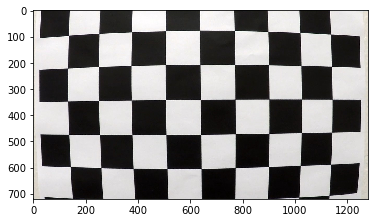

In [2]:
calib_dirs = glob.glob('./camera_cal/c*.jpg')
calib_img = plt.imread(calib_dirs[0])
plt.imshow(calib_img)


The chessboard has 9 inner corners in the x direction, and 6 in the y direction.
nx = 9, ny = 6

In [3]:
def camera_calibration(img_dirs):
    """
    Caclulates the camera calibration matrix 'mtx' and 
    distortion coefficients 'dist'.
    """
    # object points(corners) in x and y direction
    nx = 9
    ny = 6
    
    objpoints = [] # 3D points in world space
    imgpoints = [] # 2D points in image plane
    
    # prepare object points (x,y,z), like (0,0,0),... (1,0,0)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates

    for i, fname in enumerate(img_dirs):
        
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        #find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        # Found the corners of an image
        if ret == True: 
            
            objpoints.append(objp) 
            imgpoints.append(corners) 

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
    plt.imshow(img)
    # Calculate calibration parameters
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,
                                                       gray.shape[::-1], None, None)
    return mtx, dist

def save_calib_params(target_dir, mtx, dist):
    """
    Saves the camera calibration matrix 'mtx' and distortion coefficients 
    'dist' in 'target_dir' using pickle.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    with open(target_dir + '/camera_calibration.p', 'wb') as f:
        pickle.dump({'mtx': mtx, 'dist': dist}, f)        

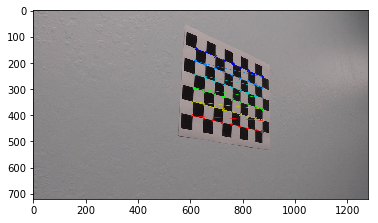

In [4]:
mtx, dist = camera_calibration(calib_dirs)
# save_calib_params("pickle_data", mtx, dist)

In [5]:
mtx, dist

(array([[  1.15777818e+03,   0.00000000e+00,   6.67113857e+02],
        [  0.00000000e+00,   1.15282217e+03,   3.86124583e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[-0.24688507, -0.02373156, -0.00109831,  0.00035107, -0.00259866]]))

### 2. Undistort images
Apply a distortion correction to raw images and save results.

In [6]:
def undistort(img, mtx, dist):
    """
    Undistorts 'img' with the camera matrix 'mtx' 
    and distortion coefficients 'dist'.
    """
    return cv2.undistort(img, mtx, dist)


def show_undist_image(img, mtx, dist):
    """
    Undistort 'img' with 'mtx' and 'dist', and 
    shows original 'img' and undistorted image.
    """
    undist_img = undistort(img, mtx, dist)
    fig, ax = plt.subplots(1,2, figsize=(15, 10))
    ax[0].imshow(img)
    ax[0].set_title("Original Image", fontsize=20)
    ax[0].axis("off")

    ax[1].imshow(undist_img)
    ax[1].set_title("Undistorted Image", fontsize=20)
    ax[1].axis("off")
    
    
def save_undist_images(img_dirs, target_dir, mtx, dist):
    """
    Undistort 'img' with 'mtx' and 'dist', and saves original 'img' 
    and undistorted image in the 'target_dir'.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    for i, img_dir in enumerate(img_dirs):
        img = plt.imread(img_dir)
        
        undist_img = undistort(img, mtx, dist)
        fig, ax = plt.subplots(1,2, figsize=(15, 10))
        ax[0].imshow(img)
        ax[0].set_title("Original Image", fontsize=20)
        ax[0].axis("off")

        ax[1].imshow(undist_img)
        ax[1].set_title("Undistorted Image", fontsize=20)
        ax[1].axis("off")
        
        # save results
        fname = target_dir + '/undistort_'+ img_dir.split('\\')[-1]
        fig.savefig(fname)
        plt.close(fig)

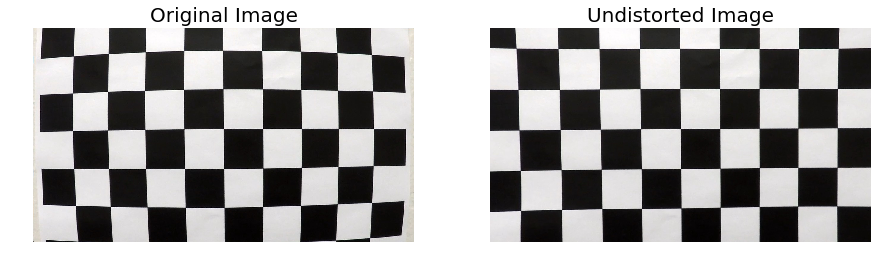

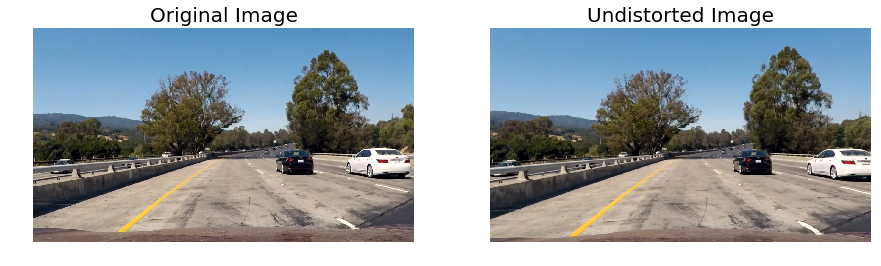

In [7]:
# Loading camera calibration
camera_calibration = pickle.load(open('./pickle_data/camera_calibration.p', 'rb' ) )
mtx, dist = map(camera_calibration.get, ('mtx', 'dist'))

show_undist_image(calib_img, mtx, dist)

test_dirs = glob.glob('./test_images/*.jpg')
test_img = plt.imread(test_dirs[2]) # RGB
show_undist_image(test_img, mtx, dist)

We can observe the change in the shape of the car hood at the bottom of images.

In [8]:
## Saves the results
# output_imgs_dir = './output_images'
# save_undist_images(calib_dirs, output_imgs_dir + '/undist_camera_cal', mtx, dist)
# save_undist_images(test_dirs, output_imgs_dir + '/undist_test_images', mtx, dist)

### 3. Color Transforms (HLS) and Sobel Gradients
Use color transforms, gradients, etc., to create a thresholded binary image.

In [9]:
def show_channels(img, channel_names):
    """
    Displays three channels of 'img' with 'channel_names'.
    """
    fig, axes = plt.subplots(1, 3, figsize=(25, 30))
    for i, ax in enumerate(axes):
        ax.imshow(img[:,:,i], cmap="gray")
        ax.set_title(channel_names[i] + " Channel", fontsize=20)
        ax.axis("off")
        
        
def display_images(images, titles, fig_size=(25, 30)):
    fig, axes = plt.subplots(1, len(images), figsize=fig_size)
    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img, cmap="gray")
        ax.set_title(titles[i], fontsize=20)
        ax.axis("off")

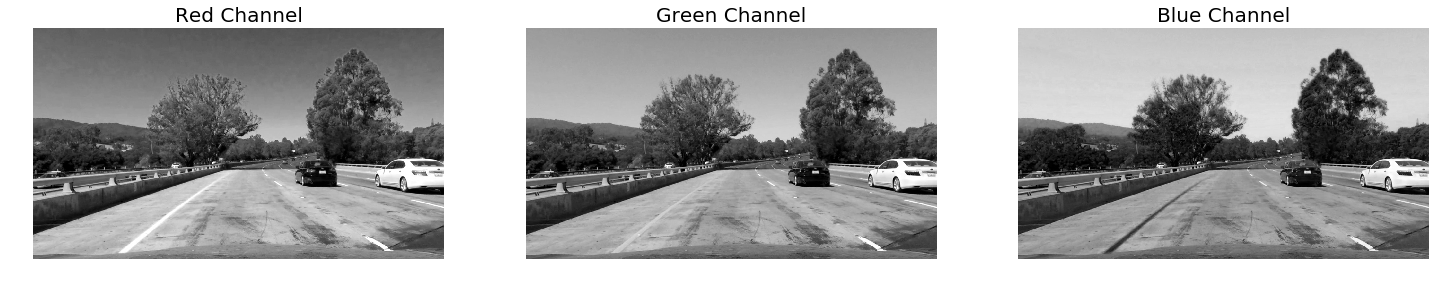

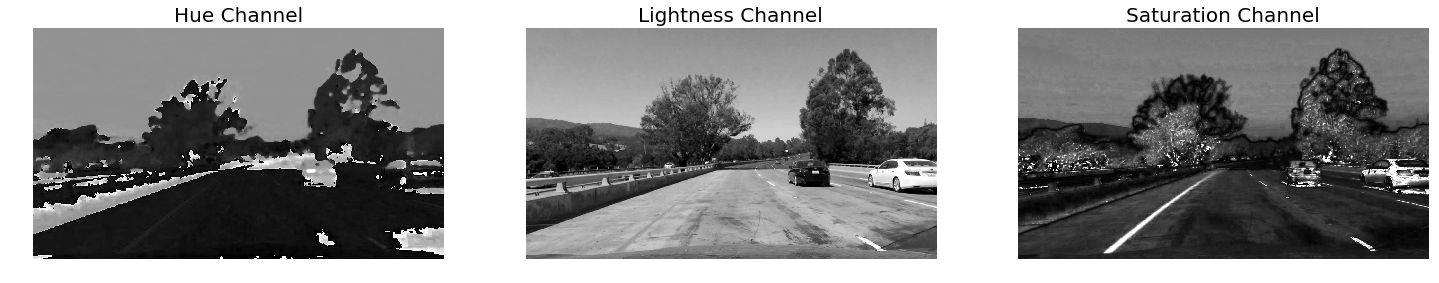

In [10]:
undist_test_img = undistort(test_img, mtx, dist)
hls_img = cv2.cvtColor(undist_test_img, cv2.COLOR_RGB2HLS) 

show_channels(undist_test_img, ["Red", "Green", "Blue"])
show_channels(hls_img, ["Hue", "Lightness", "Saturation"])

For color transforms, the saturation (**S**) channel of the image represents the best lane features. 
Therefore, we use the S-channel in HLS transform to create a thresholded binary image.

In [11]:
def hls_thresh(img, thresh=(0,255)):
    """
    Converts the `img` to HLS color space and returns a S-channel thresholded binary image.
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_img = np.zeros_like(s_channel)
    binary_img[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_img

def color_thresh(image, thresh=(30, 255)):
    img = image.copy()
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # RGB thresholding for white
    lower = np.uint8([220, 220, 220])
    upper = np.uint8([255, 255, 255])
    rgb_mask = cv2.inRange(img, lower, upper)
    
    # HLS thresholding for yellow and white
    lower = np.uint8([0, 90, 100])
    upper = np.uint8([40, 255, 255])
    hls_mask = cv2.inRange(hls, lower, upper)
    
    mask = cv2.bitwise_or(rgb_mask, hls_mask)
    color_img = cv2.bitwise_and(image, image, mask=mask)
    color_img = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
    color_binary = np.zeros_like(color_img)
    color_binary[(color_img >= thresh[0]) & (color_img <= thresh[1])] = 1
    return color_binary

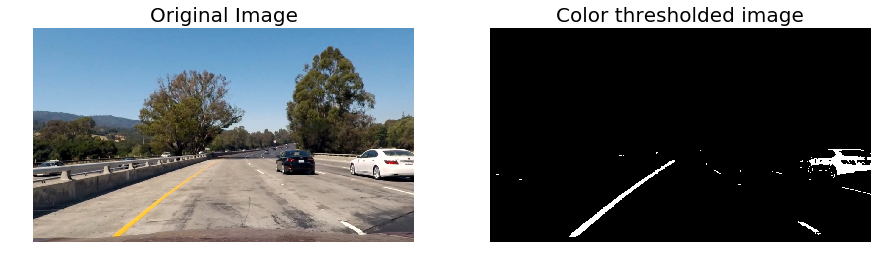

In [12]:
color_binary = color_thresh(undist_test_img)
display_images([undist_test_img, color_binary], ['Original Image', 'Color thresholded image'], fig_size=(15, 10))

**Sobel gradient threshold**: absolute gradient, magnitude, direction, or combined.

In [13]:
def abs_sobel_thresh(S_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
     Calculates the Sobel gradient on the direction `orient` and 
     returns a binary thresholded image.
    """    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(S_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(S_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Rescale to 8 bit integer (0~255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_img = np.zeros_like(scaled_sobel)
    binary_img[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_img


def mag_thresh(S_img, sobel_kernel=3, thresh=(0, 255)):
    """
     Calculates the Sobel magnitude gradient and return a binary thresholded image.
    """    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(S_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(S_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)  
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255
    scaled_sobel = np.uint8(gradmag/scale_factor)
    
    # Create a copy and apply the threshold
    binary_img = np.zeros_like(scaled_sobel)
    binary_img[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_img


def direc_thresh(S_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Calculates the Sobel direction gradient and keeps the direction 
    within the 'thres' range, then returns a binary thresholded image.
    
    """
    sobelx = cv2.Sobel(S_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(S_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)    
    grad_direc = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Create a copy and apply the threshold
    binary_img = np.zeros_like(grad_direc)
    binary_img[(grad_direc >= thresh[0]) & (grad_direc <= thresh[1])] = 1
    
    return binary_img


def combined_thresh(undist_img):
    """
    Calculates the combination of Sobel X and Sobel Y.
    """
    S_img = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)[:,:,2]
    sobel_x = abs_sobel_thresh(S_img, orient='x', thresh=(20, 140))
    sobel_y = abs_sobel_thresh(S_img, orient='y', thresh=(20, 140))
    mag_img = mag_thresh(S_img, sobel_kernel=3, thresh=(20, 120))
    dir_img = direc_thresh(S_img, sobel_kernel=3, thresh=(0.6, 1.2))
    color_img = color_thresh(undist_img)
    
    combined = np.zeros_like(S_img)
    combined[((sobel_x == 1) & (sobel_y == 1)) 
             | ((mag_img == 1) & (dir_img == 1))
             | (color_img == 1)] = 1 
    return combined

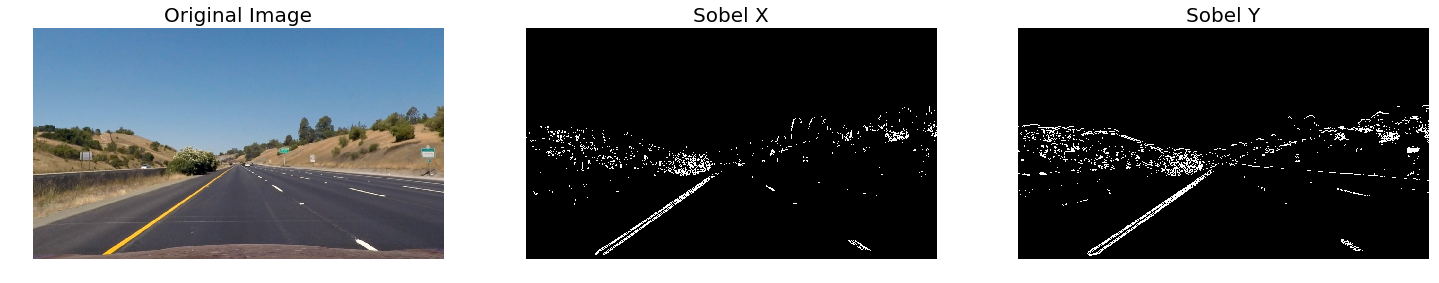

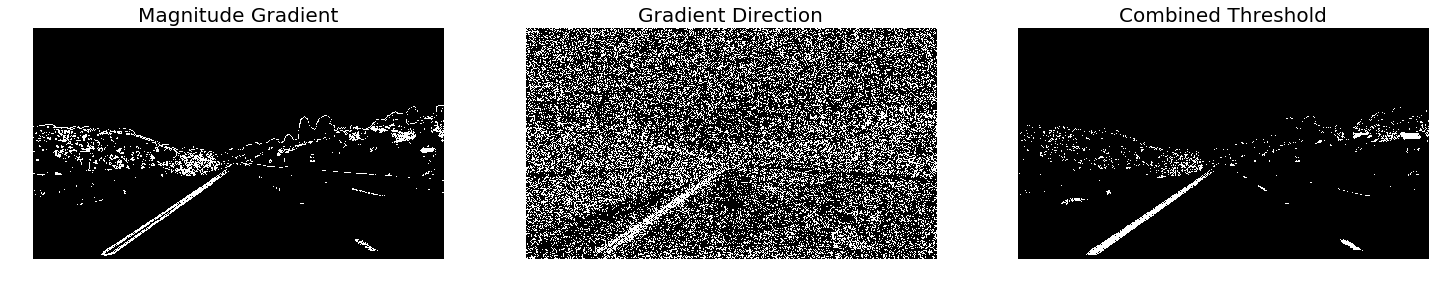

In [14]:
test_img = plt.imread(test_dirs[0]) # RGB
undist_img = cv2.undistort(test_img, mtx, dist)
undist_S_img = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)[:,:,2]

sobel_x_img = abs_sobel_thresh(undist_S_img, orient='x', thresh=(20, 140))
sobel_y_img = abs_sobel_thresh(undist_S_img, orient='y', thresh=(20, 140))
mag_img = mag_thresh(undist_S_img, sobel_kernel=3, thresh=(20, 120))
dir_img = direc_thresh(undist_S_img, sobel_kernel=3, thresh=(0.6, 1.2))
combined_img = combined_thresh(undist_img)

display_images([undist_img, sobel_x_img, sobel_y_img], ['Original Image', 'Sobel X', 'Sobel Y'])
display_images([mag_img, dir_img, combined_img], ['Magnitude Gradient', 'Gradient Direction', 'Combined Threshold'])

### 4. Perspective Transform
Apply a perspective transform to rectify binary image ("birds-eye view").

In [15]:
original_img = plt.imread(test_dirs[0])
h, w, _ = original_img.shape
offset = 300

# source points
src = np.float32([[205, h],
                  [585, 460],
                  [700, 460],
                  [1100, h]])
# destination points
dst = np.float32([[offset, h],
                  [offset, 0],
                  [w - offset, 0],
                  [w - offset, h]])

# obtain perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def drawn_and_warped(image, M, src, mtx, dist, line=True, thres=False):
    """
    Performs a perspective transform of `image` to get a warped image;
    and returns the 'image' with the 'src' region drawn.
    """
    img = image.copy()
    pts = src.astype(np.int32)
    drawn = cv2.polylines(img, [pts], True, (255, 0, 0), 3) if line else img
    
    img_size = img.shape[:2][::-1]
    
    # Uses Sobel gradient to obtain a thresholded binary image. 
    if thres:
        undist_img = cv2.undistort(image, mtx, dist)
        image = combined_thresh(undist_img) 
    else:
        pass

    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return drawn, warped

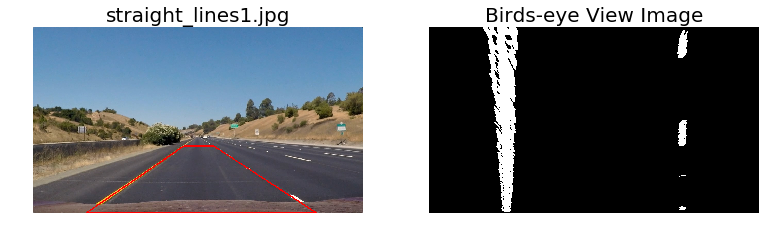

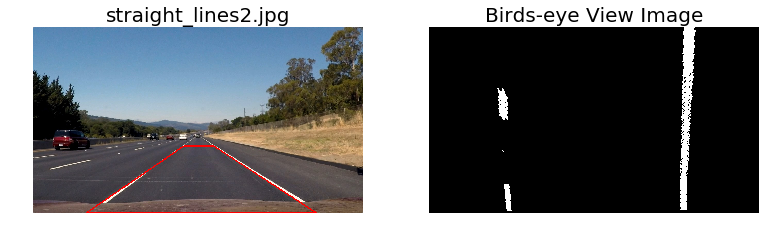

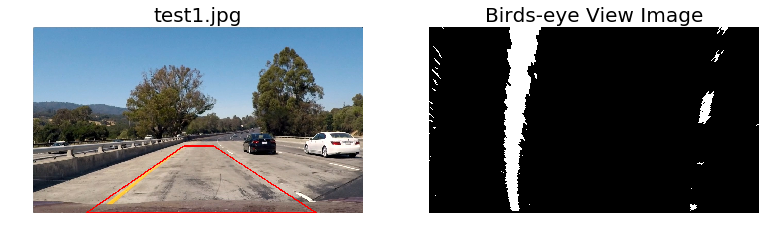

In [16]:
def display_drawn_warped(drawn, warped, img_name):
    """
    Displays the drawn image and perspective transformed image.
    """
    fig, ax = plt.subplots(1,2, figsize=(13, 10))
    
    ax[0].imshow(drawn)
    ax[0].set_title(img_name, fontsize=20)
    ax[0].axis("off")

    ax[1].imshow(warped, cmap="gray")
    ax[1].set_title("Birds-eye View Image", fontsize=20)
    ax[1].axis("off")
    
test_dirs = glob.glob('./test_images/*.jpg')[:3]
test_images = list(map(plt.imread, test_dirs))
for (img_dir, img) in zip(test_dirs, test_images):
    drawn, warped = drawn_and_warped(img, M, src, mtx, dist, line=True, thres=True)
    img_name = img_dir.split('\\')[-1]
    display_drawn_warped(drawn, warped, img_name)

In [17]:
def warp(undist_image, M, binary_output=True):
    combined = combined_thresh(undist_image) if binary_output else undist_image
    img_size = undist_image.shape[:2][::-1]
    return cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

### 5.  Fit Lane Lines
Detect lane pixels and fit to find the lane boundary.

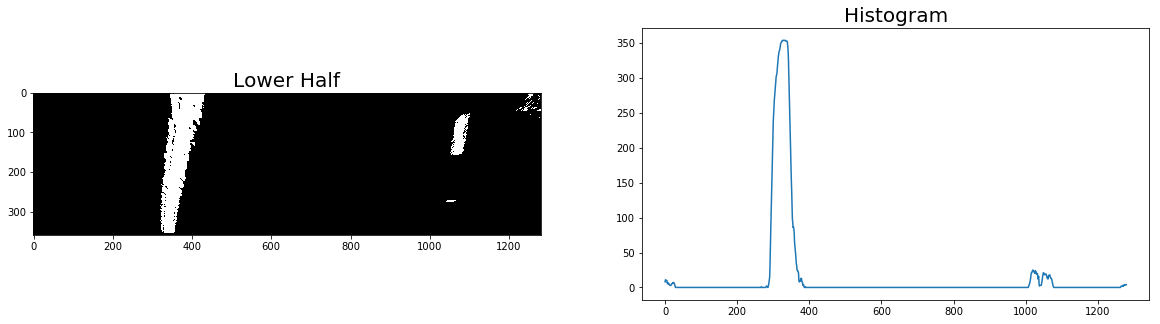

In [18]:
test_dirs = glob.glob('./test_images/*.jpg')
test_fit_img = plt.imread(test_dirs[-1]) # RGB
undist_fit_img = cv2.undistort(test_fit_img, mtx, dist)
binary_warped = warp(undist_fit_img, M)

# calculate the histogram of the bottom half of the image and plot
lower_half = binary_warped[binary_warped.shape[0]//2:, :]
histogram = np.sum(warped[binary_warped.shape[0]//2:, :], axis=0)

# display_images([lower_half, histogram], ['Lower Bottom of the Image', 'Histogram'])
f, axes = plt.subplots(1,2, figsize=(20, 5))

axes[0].imshow(lower_half, cmap='gray')
axes[0].set_title('Lower Half', fontsize=20)
axes[1].plot(histogram)
axes[1].set_title('Histogram', fontsize=20)

In [71]:
def fit_poly(leftx, lefty, rightx, righty, img_shape):
    """
    Fits polynoimials of two lane lines in image.
    """
    # Fit a second order polynomial to each line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

In [72]:
def fit_lanes_first(binary_warped, nwindows=9, margin=100, minpix=30):
    """
    Searchs lane pixels through sliding windows, then performs a polynomial 
    fit to the lane lines in the "image". 
    - `nwindows`: the number of sliding windows.
    - `margin`: the windows margin.
    - `minpix`: minimum number of pixes found to recenter the window.
    """
    # plot the histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    
    # visualize the output image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
 
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        winx_left_low = leftx_current - margin
        winx_left_high = leftx_current + margin
        winx_right_low = rightx_current - margin
        winx_right_high = rightx_current + margin
    
        # Draw the windows on the image
        cv2.rectangle(out_img, (winx_left_low, win_y_low), 
                     (winx_left_high, win_y_high), (0,255,0), 3)
        cv2.rectangle(out_img, (winx_right_low, win_y_low), 
                     (winx_right_high, win_y_high), (0,255,0), 3)
        
        # Identify nonzero pixels within the window
        good_left_inds = ((nonzerox >= winx_left_low) & (nonzerox < winx_left_high) & 
                          (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        
        good_right_inds = ((nonzerox >= winx_right_low) & (nonzerox < winx_right_high) & 
                          (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recenter next window on the mean position of points
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Change the color of left and right lane pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(leftx, lefty, rightx, 
                                                                 righty, binary_warped.shape)
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

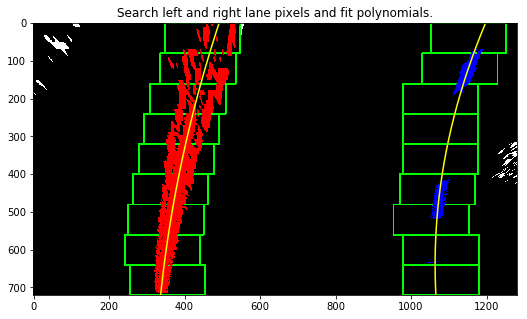

In [73]:
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_lanes_first(binary_warped)

plt.figure(figsize=(10,5))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color = 'yellow')
plt.plot(right_fitx, ploty, color = 'yellow')
plt.title("Search left and right lane pixels and fit polynomials.")

In [74]:
def fit_lanes_next(binary_warped, left_fit, right_fit, margin=100):
    """
    Skip the sliding window step once the fit polynomial is known.
    """
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    left_lane_inds = ((nonzerox >= (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                      left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) 
                      + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox >= (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                      right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) 
                      + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]    
    rightx = nonzerox[right_lane_inds]    
    righty = nonzeroy[right_lane_inds]    
    
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(leftx, lefty, rightx, 
                                                                 righty, binary_warped.shape)
    # Create an image to draw on 
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Set color for left and right lane pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    #  Generate a polygon to present search window region
    left_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_window1, left_window2))
    
    right_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_window1, right_window2))
    
    # Draw lanes on the blank warped image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), color=(0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), color=(0, 255, 0))    
    
    res_img = cv2.addWeighted(out_img, 0.5, window_img, 0.25, 0)
    return res_img, left_fit, right_fit, left_fitx, right_fitx, ploty

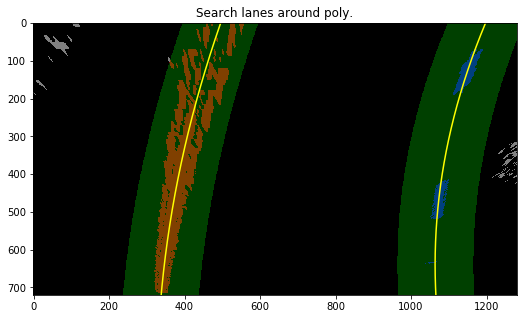

In [75]:
res_img, left_fit, right_fit, left_fitx, right_fitx, ploty =fit_lanes_next(binary_warped, left_fit, right_fit)

plt.figure(figsize=(10,5))
plt.imshow(res_img)
plt.plot(left_fitx, ploty, color = 'yellow')
plt.plot(right_fitx, ploty, color = 'yellow')
plt.title("Search lanes around poly.")

### 6. Calulate Lane Curvature
Determine the curvature of the lane and vehicle position with respect to center.

In [76]:
def curvature(x, y, xm, ym):
    # Define y-value where we want radius of curvature, corresponding to the bottom of the image
    y_eval = np.max(y)
    
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y*ym, x*xm, 2)
    curvature = ((1 + (2*fit_cr[0]*y_eval*ym + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curvature

def measure_curvature(left_fitx, right_fity, ploty, img_size):
    """
    -`img_size`: (x_size, y_size)
    """
    # Conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_curve = curvature(left_fitx, ploty, xm_per_pix, ym_per_pix)
    right_curve = curvature(right_fitx, ploty, xm_per_pix, ym_per_pix)
    curve_radias = (left_curve + right_curve)/2
    
    # line intercepts on x axis
    left_intcpt = left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]
    right_intcpt = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]
    
    # Calculate midpoint of lane line
    lane_mid = (left_intcpt + right_intcpt)/2.0
    center_dist = (img_size[0]/2.0 - lane_mid) * xm_per_pix
    return curve_radias, center_dist

In [77]:
img_size = binary_warped.shape[::-1]
curve_radias, center_dist = measure_curvature(left_fitx, right_fitx, ploty, img_size)
curve_radias, center_dist

(708.86072515271803, -0.32788502121581137)

### 7. Warp lanes
Warp the detected lane boundaries back onto the original image.

In [64]:
def warp_lane_boundries(binary_warped, left_fit, right_fit, Minv, undist_img):
    """
    Warps the detected lane boundaries back onto the original image.
    """
    orig_img = undist_img.copy()
    zero_warped = np.zeros_like(binary_warped)
    out_img = np.dstack((zero_warped, zero_warped, zero_warped))
    img_shape = binary_warped.shape[::-1]
    
    ploty = np.linspace(0, img_shape[1]-1, img_shape[1])
    left_fitx = left_fit[0]*ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    left_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((left_pts, right_pts))
    
    cv2.fillPoly(out_img, np.int_([pts]), (0, 255, 0))
    cv2.polylines(out_img, np.int32([left_pts]), isClosed=False, color=(255, 0, 0), thickness=10)
    cv2.polylines(out_img, np.int32([right_pts]), isClosed=False, color=(0, 0, 255), thickness=10)
    
    new_warped = cv2.warpPerspective(out_img, Minv, img_shape)
    res_img = cv2.addWeighted(orig_img, 1, new_warped, 0.5, 0)
    return res_img

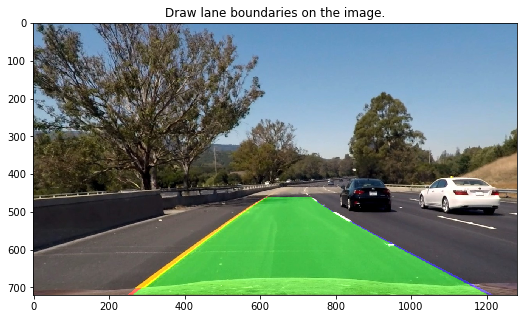

In [65]:
final_img = warp_lane_boundries(binary_warped, left_fit, right_fit, Minv, undist_fit_img)

plt.figure(figsize=(10,5))
plt.imshow(final_img)
plt.title("Draw lane boundaries on the image.")

### 8. Display Results
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

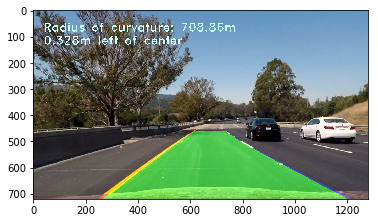

In [81]:
def display_on_images(img, curve_radias, center_dist):
    font = cv2.FONT_HERSHEY_DUPLEX
    image = img.copy()
    
    curve_text = 'Radius of curvature: ' + str(np.round(curve_radias, 2)) + 'm'
    if center_dist > 0:
        direc = 'right'
    else:
        direc = 'left'
    
    dist_text = str(np.round(abs(center_dist), 3)) + 'm ' + direc + ' of center'
    
    cv2.putText(image, curve_text, (40, 80), font, 1.5, (200, 255, 255), 2)
    cv2.putText(image, dist_text, (40, 130), font, 1.5, (200,255,255), 2)    
    return image

display_final = display_on_images(final_img, curve_radias, center_dist)
plt.imshow(display_final)
plt.imsave('output_images/final_result', display_final)